In [270]:
import controllers
import controlpy
import control_utils
import dynamics_models
import experiment_utils
import numpy as np
import matplotlib.pyplot as plt
import polytope
import tqdm
import uncertainty_utils
import trajectory_optimizers
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## Setup Drone Dynamics

In [271]:
# Dynamics Parameters
n_states = 6
n_inputs = 2
dt = 0.1
m = 0.5
l = 0.4
I = (1 / 3) * m * (l**2)
init_state = np.array([3, 3,0,.3,.3,0])
state_limits = polytope.box2poly([[-2,4],[-2,4],[-np.pi/3, np.pi/3]])
u_min = -.01
u_max = 5
input_limits = polytope.box2poly([[u_min,u_max], [u_min,u_max]])
input_bounds = [np.array([u_min, u_min]), np.array([u_max, u_max])]

# Control Task
Q = np.diag([10,10,1,1,1,1])
R = np.eye(n_inputs)
h = lambda x, u: (x - state_reference).T @ Q @ (x - state_reference) + (u - input_reference).T @ R @ (u - input_reference)

# Noise and Disturbances
process_noise_var = 0
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
# disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n_states))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(5 / dt)
controller_horizon = 5
num_episodes = 15
state_reference = np.zeros(n_states)
input_reference = np.ones(n_inputs) * m * 9.81 / n_inputs 
A_state = np.hstack((state_limits.A, np.zeros((state_limits.A.shape[0],3))))
state_constraints = (A_state, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)
invariant_alpha = 0.05

# Vehicle
def get_vehicle():
    vehicle = dynamics_models.PlanarQuadrotor(init_state, m, l , I, dt, process_noise)
    return vehicle

def model_callback(vehicle, controller, episode_length):
    u_ss = controller.input_safe_set @ controller.multipliers.value
    input_traj = np.vstack((controller.u_traj[:,1:].value.T, u_ss)).T
    A, B, C = control_utils.linearize_around(vehicle, controller.x_traj[:,1:].value, input_traj, vehicle.dt)
    return A, B, C
# def model_callback(vehicle, controller, episode_length):
#     A, B, C = control_utils.linearize_around(vehicle, controller.x_traj.value, controller.u_traj.value, vehicle.dt)
#     return A, B, C

## Plotting 
figsize=(6,6)
def plot_experiment(traj_list, x_preds, ax, lims=(-3,5), lw=2, k=5):
    state_proj = state_limits.project(np.arange(2) + 1)
    ax.axis("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("x (in m)")
    ax.set_ylabel("y (in m)")
    state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

    for x_traj in traj_list:
        ax.plot(x_traj[0,:], x_traj[1,:], "k--")

    x_traj = traj_list[-1].T
    ax.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

    for x_pred in x_preds[::k]:
        ax.plot(x_pred[:,0], x_pred[:,1], "r--")

## Run initial Iteration, Tracking MPC

In [272]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(state_reference, input_reference, dt)
controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon, 
                                         Q,  R, state_reference, input_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [273]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
init_value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
print(init_value_function[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.47it/s]


2065.290488466044


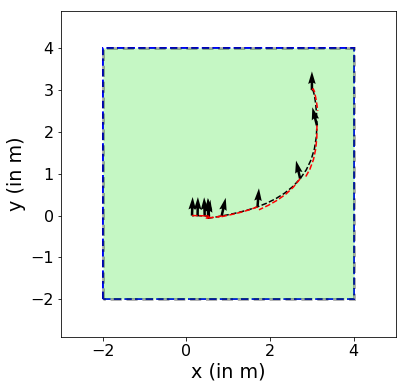

In [274]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_init_traj.T], x_init_preds, ax)
O = polytope.Polytope(*controller.terminal_constraint)
Op = O.project([1,2])
Op.plot(ax, alpha=0.3)

## Setup LTI style LMPC

In [275]:
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [276]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.93it/s]


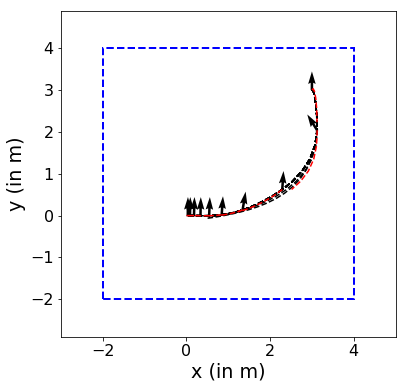

In [277]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

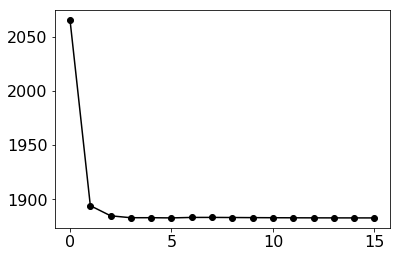

In [278]:
lti_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(lti_lmpc_costs, "k-o")

## Naive LTV LMPC

In [279]:
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [280]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_init_traj[:controller.N,:].T, u_init_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.98it/s]


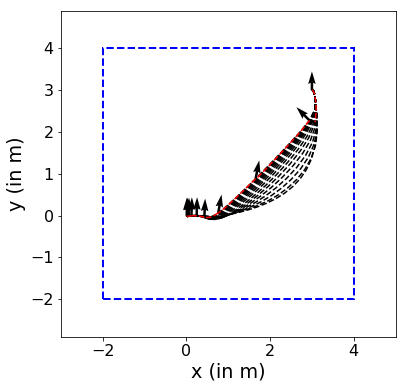

In [281]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

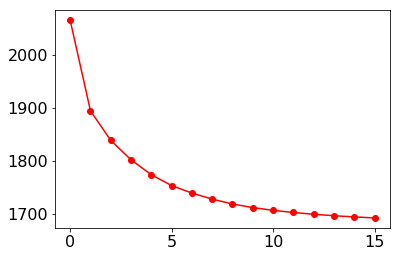

In [282]:
naive_ltv_costs = [q[0] for q in controller.value_func_list]
# plt.plot(lti_lmpc_costs, "k-o")
plt.plot(naive_ltv_costs, "r-o")

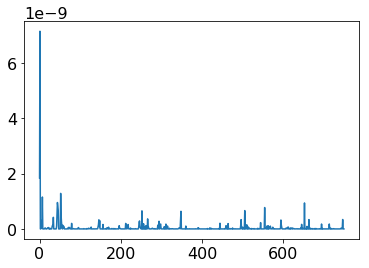

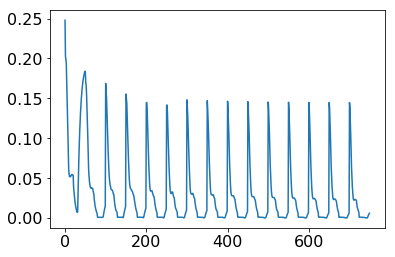

In [283]:
slack_list = [np.linalg.norm(slack) for slacks in slack_per_episode for slack in slacks]
terminal_slack_list = [np.linalg.norm(tslack) for tslacks in term_slack_per_episode for tslack in tslacks]
plt.figure()
plt.plot(slack_list)
plt.figure()
plt.plot(terminal_slack_list)

## LTI Tube LMPC
Don't RUN! COMPUTING MINIMAL INVARIANTS IN HIGH DIM IS NOT REALISTIC WITHOUT A PROPER FAST APPROXIMATION. It takes forever both in Matlab and in my python implementation, which largely uses the same methods as the MPT toolbox. Many projects that do control for "high" dimensional systems (i.e. n > 3) run into this problem. For example in [^1], they just subtract the disturbance set from the constraint sets to compute constraint tightenings... I'm sure there are a bunch of approximations that exist but they'll make things more conservative and/or also won't really be invariant. 

[^1]: A. Aswani, P. Bouffard, C. Tomlin, Extensions of Learning-Based Model Predictive Control for Real-Time
Application to a Quadrotor Helicopter

In [284]:
# num_episodes = 10

# controller = controllers.LTI_Tube_LMPC(A, B, C,
#                                      controller_horizon, 
#                                      Q, R, state_reference, 
#                                      state_constraints, input_constraints, 
#                                     (disturbance_bound.A, disturbance_bound.b))
# h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
# value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
# controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [285]:
# for episode in range(num_episodes):
#     vehicle = get_vehicle()
#     x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
#     value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
#     controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

## LTI MPC

In [286]:
controller = controllers.LTI_MPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference, 
                                     state_constraints, input_constraints)
controller.build()

In [287]:
vehicle = get_vehicle()
x_traj, u_traj, x_preds, u_preds, _, _ = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.75it/s]


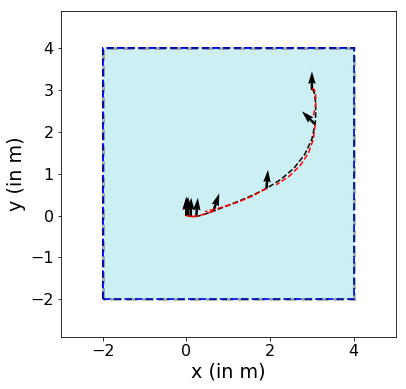

In [288]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_traj.T], x_preds, ax)

Op = O.project([1,2])
Op.plot(ax=ax, alpha=0.3)
fixed_lti_mpc_cost = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)

## Local Safe Sets, TV LMPC

In [289]:
safe_set_size = 50
n_safe_set_it = 5
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [290]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.17it/s]


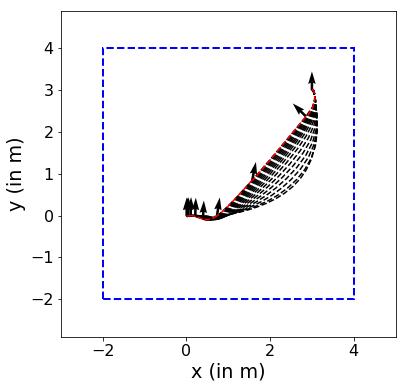

In [291]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

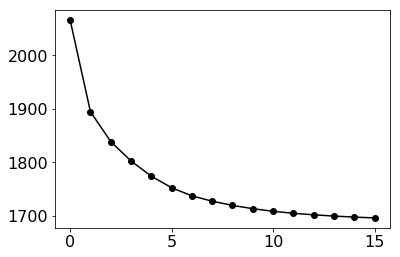

In [292]:
local_ltv_costs = [q[0] for q in controller.value_func_list]
plt.plot(local_ltv_costs, "k-o")

## True TV LMPC

In [293]:
controller = controllers.True_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

def ltv_model_callback(vehicle, controller, episode_length):
    i = controller.i
    N = controller.N
    i = min(episode_length - N, i)
    x_traj = controller.traj_list[-1][:,i:i+N]
    u_traj = controller.input_traj_list[-1][:,i:i+N]
    A, B, C = control_utils.linearize_around(vehicle, x_traj, u_traj, vehicle.dt)
    return A, B, C

In [294]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=ltv_model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.22it/s]


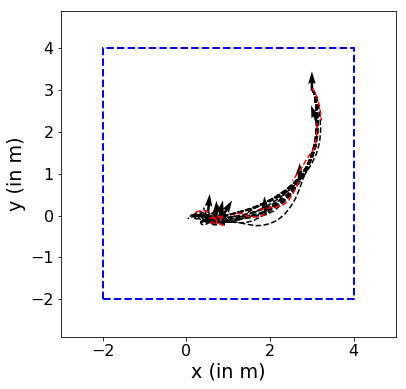

In [295]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

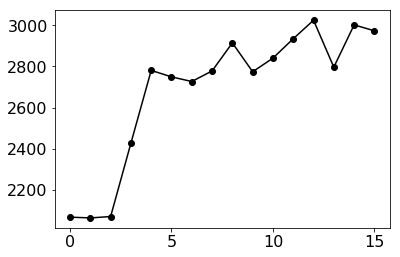

In [296]:
true_ltv_costs = [q[0] for q in controller.value_func_list]
plt.plot(true_ltv_costs, "k-o")

## Quasi LBLMPC

In [297]:
controller = controllers.LBLMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, (disturbance_bound.A, disturbance_bound.b))
## Minimal Invariant Cannot Be Computed

M = polytope.box2poly([[-invariant_alpha, invariant_alpha]] * n_states)
X = polytope.Polytope(*controller.state_constraints)
U = polytope.Polytope(*controller.input_constraints)
X_bar = control_utils.pontryagin_difference(X, M)
U_bar = control_utils.pontryagin_difference(U, control_utils.poly_transform(M, controller.K))
controller.state_constraints = (X_bar.A, X_bar.b)
controller.input_constraints = (U_bar.A, U_bar.b)
controller.init_constraint = (M.A, M.b)


controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)


In [298]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.70it/s]


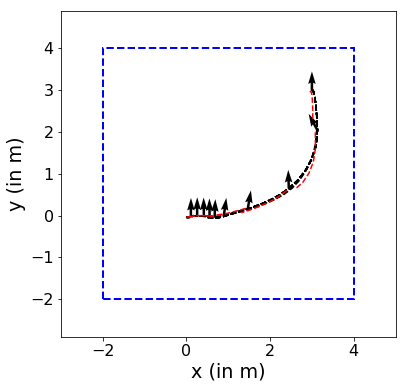

In [299]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

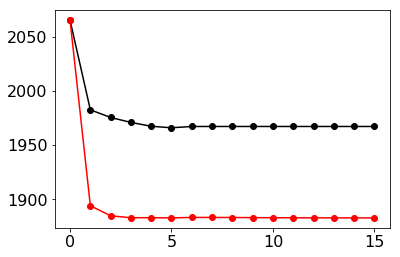

In [300]:
lblmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(lblmpc_costs, "k-o")
plt.plot(lti_lmpc_costs, "r-o")

### LTV Tube LMPC

In [301]:
## Minimal Invariant Cannot Be Computed
M = polytope.box2poly([[-invariant_alpha, invariant_alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Tube_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, minimal_invariant)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)


In [302]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.66it/s]


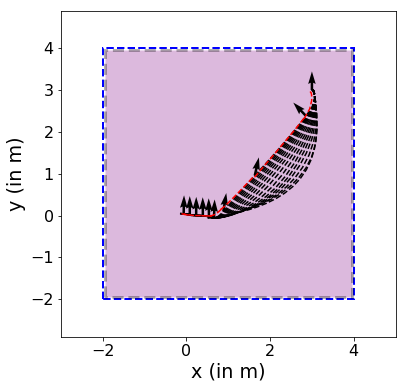

In [303]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.project((1,2)).plot(ax, alpha=0.3)

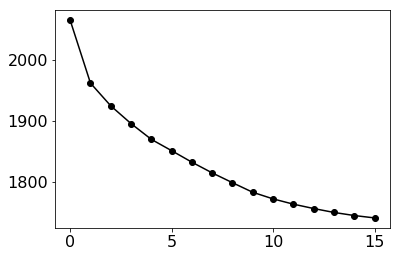

In [304]:
ltv_tube_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(ltv_tube_lmpc_costs, "k-o")

## LTV Robust LMPC

In [305]:
## Minimal Invariant Cannot Be Computed
invariant_alpha = 0.05
M = polytope.box2poly([[-invariant_alpha, invariant_alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Robust_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, minimal_invariant)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)


In [306]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.17it/s]


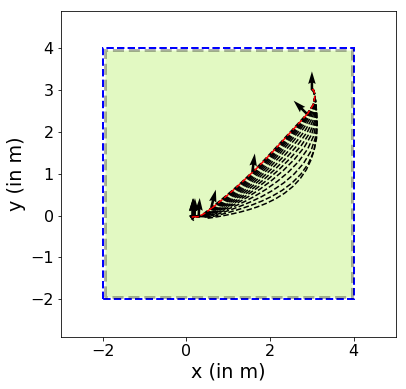

In [307]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.project((1,2)).plot(ax, alpha=0.3)

In [308]:
print(ltv_robust_lmpc_costs)

[3404.615925544602, 3388.1175684111286, 3326.342335179899, 3299.2033363351275, 3282.1570810145777, 3269.8863649595933, 3261.3988420933206, 3257.3341372578298, 3255.1489721908856, 3253.9349322027692, 3252.233308997914, 3250.9392104501057, 3249.909075720843, 3248.7752003686096, 3247.2582508238684, 3246.134195189086]


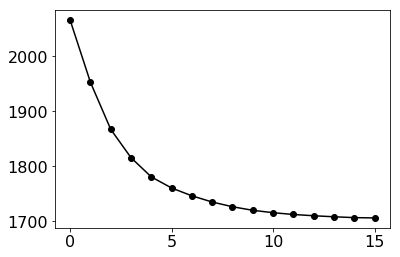

In [309]:
ltv_robust_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(ltv_robust_lmpc_costs, "k-o")

In [310]:
controller.input_traj_list[-1]

array([[2.79172, 0.33636, 0.36173, 1.62738, 2.6654 , 1.91722, 1.9022 ,
        2.46642, 3.00579, 3.30434, 3.44045, 3.53711, 3.51676, 3.38693,
        3.29462, 3.24596, 3.06173, 2.84721, 2.71584, 2.66518, 2.55584,
        2.5353 , 2.47665, 2.45121, 2.42654, 2.43178, 2.44464, 2.44678,
        2.44781, 2.44916, 2.45024, 2.45113, 2.45185, 2.45278, 2.45495,
        2.45532, 2.45274, 2.45386, 2.45574, 2.45738, 2.45805, 2.45765,
        2.45599, 2.45478, 2.45364, 2.45275, 2.45206, 2.45157, 2.45124,
        2.45105],
       [0.35053, 0.36285, 0.61589, 4.60502, 3.72602, 1.95385, 1.50496,
        1.94123, 2.60605, 3.10387, 3.35774, 3.47022, 3.38781, 3.24998,
        3.17203, 3.09146, 3.02068, 2.91534, 2.8012 , 2.68048, 2.64892,
        2.55481, 2.50549, 2.4701 , 2.44122, 2.4395 , 2.4394 , 2.43998,
        2.44229, 2.44585, 2.44859, 2.45062, 2.45208, 2.45331, 2.45486,
        2.4502 , 2.45391, 2.45778, 2.46043, 2.46109, 2.46051, 2.45775,
        2.45654, 2.45529, 2.45432, 2.45345, 2.45274, 2.4521

## True LTV Robust LMPC

In [311]:
## Minimal Invariant Cannot Be Computed
M = polytope.box2poly([[-invariant_alpha, invariant_alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.True_LTV_Robust_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, minimal_invariant)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [312]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=ltv_model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.55it/s]


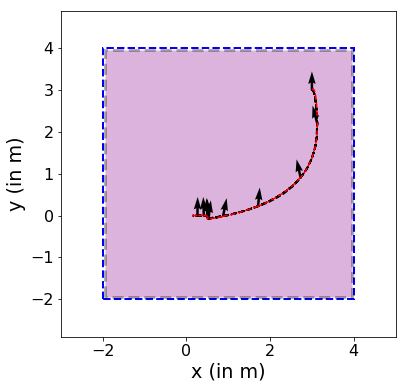

In [313]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.project((1,2)).plot(ax, alpha=0.3)

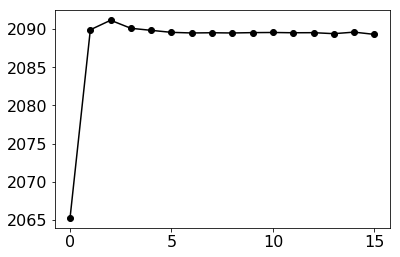

In [314]:
true_ltv_robust_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(true_ltv_robust_lmpc_costs, "k-o")

## Trajectory Optimization with SCP

In [315]:
traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, state_reference, input_reference, state_constraints, input_constraints, tolerance=1e-3, regularization=1e1)
traj_opt.build()

In [316]:
for i in range(30):
    vehicle = get_vehicle()
    if i == 0:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_init_traj.T, u_init_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
    else:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj.T, u_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)
    
    controller = traj_opt.get_controller()
    vehicle = get_vehicle()
    x_traj, u_traj, _, _, _, _ = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
    if converged:
        break
print("converged in %d iterations" % traj_opt.i)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2202.45it/s]


converged in 30 iterations


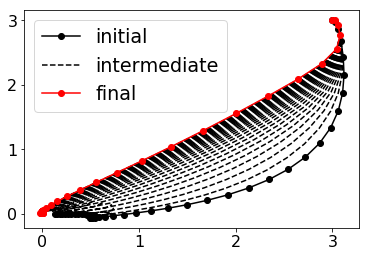

In [317]:
plt.plot(traj_opt.traj_list[0][0,:], traj_opt.traj_list[0][1,:], "k-o", label="initial")
for traj in traj_opt.traj_list[1:-1]:
    plt.plot(traj[0,:], traj[1,:], "k--", label="intermediate")
plt.plot(traj_opt.traj_list[-1][0,:], traj_opt.traj_list[-1][1,:], "r-o", label="final")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[0], handles[1], handles[-1]], [labels[0], labels[1], labels[-1]])

1638.1874143525665


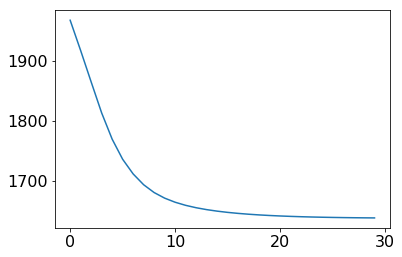

In [318]:
plt.plot(traj_opt.solution_costs)
print(traj_opt.solution_costs[-1])

In [319]:
true_scp_cost = control_utils.compute_traj_cost(x_traj.T[:,:-1], traj_opt.input_traj_list[-1], h)
print(true_scp_cost[0])

1638.195083582195


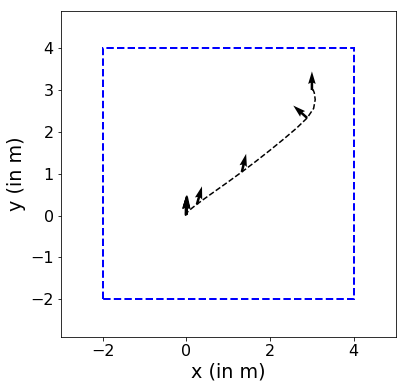

In [320]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_traj.T], [], ax)


## Plot Results

In [321]:
horizon = "short"
init_controller = "tracker"
save_dir = "drone_trajopt_expts_v3/"

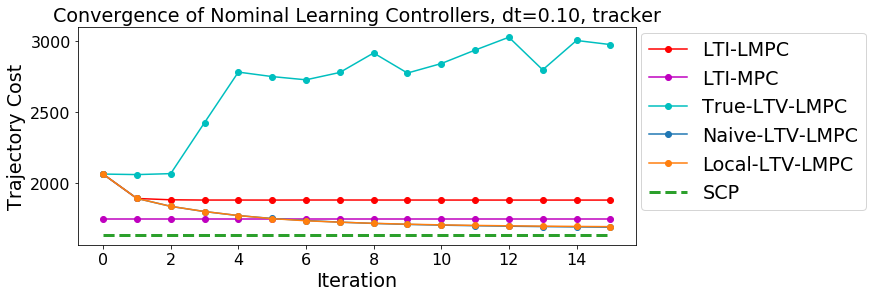

In [323]:
plt.figure(figsize=(10,4))
# plt.plot(lblmpc_costs, "k-o", label="LBLMPC")
plt.plot(lti_lmpc_costs, "r-o", label="LTI-LMPC")
# plt.plot(ltv_tube_lmpc_costs, "b-o", label="LTV-TUBE-LMPC")
plt.plot(np.arange(num_episodes+1), np.ones(num_episodes+1) * fixed_lti_mpc_cost[0], "m-o", label="LTI-MPC")
plt.plot(true_ltv_costs, "c-o", label="True-LTV-LMPC")
plt.plot(naive_ltv_costs, "-o", label="Naive-LTV-LMPC")
plt.plot(local_ltv_costs, "-o", label="Local-LTV-LMPC")
# plt.plot(ltv_robust_lmpc_costs, "-o", label="LTV-Robust-LMPC")
# plt.plot(true_ltv_robust_lmpc_costs, "-o", label="True-LTV-Robust-LMPC")
plt.plot(np.arange(num_episodes+1), np.ones(num_episodes+1) * true_scp_cost[0], "--", label="SCP", lw=3)
plt.xlabel("Iteration")
plt.ylabel("Trajectory Cost")
plt.title("Convergence of Nominal Learning Controllers, dt=%.2f, "% dt + init_controller)
plt.legend(loc="upper right", bbox_to_anchor=(1.43,1.02))
# plt.ylim(1625, 1800)
plt.savefig(save_dir + "drone_converge_nominal_" + horizon + "_" + init_controller + "_%.0fhz.png" % (1/dt), bbox_inches="tight")

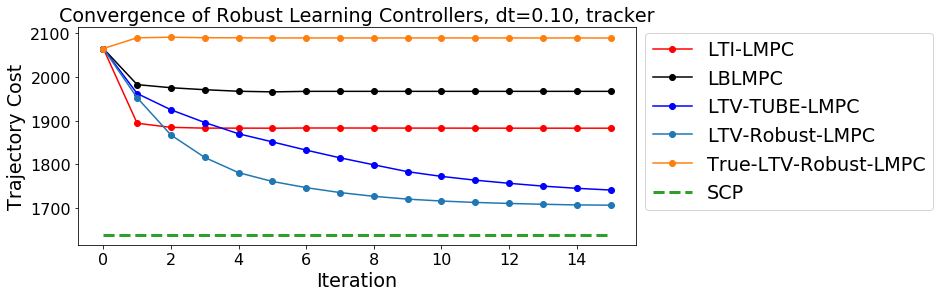

In [325]:
plt.figure(figsize=(10,4))
plt.plot(lti_lmpc_costs, "r-o", label="LTI-LMPC")
plt.plot(lblmpc_costs, "k-o", label="LBLMPC")
plt.plot(ltv_tube_lmpc_costs, "b-o", label="LTV-TUBE-LMPC")
plt.plot(ltv_robust_lmpc_costs, "-o", label="LTV-Robust-LMPC")
plt.plot(true_ltv_robust_lmpc_costs, "-o", label="True-LTV-Robust-LMPC")
plt.plot(np.arange(num_episodes+1), np.ones(num_episodes+1) * true_scp_cost[0], "--", label="SCP", lw=3)
plt.xlabel("Iteration")
plt.ylabel("Trajectory Cost")
plt.title("Convergence of Robust Learning Controllers, dt=%.2f, "  % dt + init_controller)
plt.legend(loc="upper right", bbox_to_anchor=(1.55,1.02))
# plt.ylim(2500, 5000)

plt.savefig(save_dir + "drone_converge_robust_" + horizon + "_" + init_controller + "_%.0fhz.png" % (1/dt), bbox_inches="tight")

In [141]:
controller_horizon

10